Made possible due to a great blog about 'Being Bayesian in Python' - http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/

Using a Bayesian approach, a linear regression model is compared to a GHK current flux model (https://en.wikipedia.org/wiki/GHK_flux_equation).

In [33]:
import emcee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [90]:
# Create some convenience routines for plotting

def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)


def plot_MCMC_trace(ax, xdata, ydata, trace, scatter=False, **kwargs):
    """Plot traces and contours"""
    xbins, ybins, sigma = compute_sigma_level(trace[0], trace[1])
    ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955], **kwargs)
    if scatter:
        ax.plot(trace[0], trace[1], ',k', alpha=0.1)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    
    
def plot_MCMC_model(ax, xdata, ydata, trace):
    """Plot the linear model and 2sigma contours"""
    ax.plot(xdata, ydata, 'ok')

    alpha, beta = trace[:2]
    xfit = np.linspace(-200, 200, 10)
    yfit = alpha[:, None] + beta[:, None] * xfit
    mu = yfit.mean(0)
    sig = 2 * yfit.std(0)

    ax.plot(xfit, mu, '-k')
    ax.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

    ax.set_xlabel('x')
    ax.set_ylabel('y')


def plot_MCMC_results(xdata, ydata, trace, colors='k'):
    """Plot both the trace and the model together"""
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    plot_MCMC_trace(ax[0], xdata, ydata, trace, True, colors=colors)
    plot_MCMC_model(ax[1], xdata, ydata, trace)

# Define our posterior using Python functions
# for clarity, I've separated-out the prior and likelihood
# but this is not necessary. Note that emcee requires log-posterior

##### LINEAR MODEL

def log_prior(theta):
    alpha, beta, sigma = theta
    if sigma < 0:
        return -np.inf  # log(0)
    else:
        return -1.5 * np.log(1 + beta ** 2) - np.log(sigma)

def log_likelihood(theta, x, y):
    alpha, beta, sigma = theta
    y_model = alpha + beta * x
    return -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (y - y_model) ** 2 / sigma ** 2)

def log_posterior(theta, x, y):
    return log_prior(theta) + log_likelihood(theta, x, y)


##### GHK MODEL

def log_prior_GHK(theta):
    alpha, beta, sigma = theta
    if sigma < 0:
        return np.inf  # log(0)
    else:
        return -1.5 * np.log(1 + beta ** 2) - np.log(sigma)

def log_likelihood_GHK(theta, x, y):
    alpha, beta, sigma = theta
    #y_model  =  x * beta * 0.000401 * ((1 - 0.1*np.exp(-x*0.000401)) / ( 1 - np.exp(-x*0.000401)))
    y_model = alpha + (0.0259)*np.log10((beta + x) / (beta*x + 1))
    return -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (y - y_model) ** 2 / sigma ** 2)

def log_posterior_GHK(theta, x, y):
    return log_prior_GHK(theta) + log_likelihood_GHK(theta, x, y)



def plot_MCMC_trace_GHK(ax, xdata, ydata, trace, scatter=False, **kwargs):
    """Plot traces and contours"""
    xbins, ybins, sigma = compute_sigma_level(trace[0], trace[1])
    ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955], **kwargs)
    if scatter:
        ax.plot(trace[0], trace[1], ',k', alpha=0.1)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    
    
def plot_MCMC_model_GHK(ax, xdata, ydata, trace):
    """Plot the linear model and 2sigma contours"""
    ax.plot(xdata, ydata, 'ok')

    alpha, beta = trace[:2]
    xfit = np.linspace(0.002, 0.008, 10)
    #yfit  = alpha[:, None] + xfit * beta[:, None] * 0.000401 * (  (1 - 0.1*np.exp(-xfit*0.000401)) / ( 1 - np.exp(-xfit*0.000401)))
    yfit = alpha[:, None] + (0.0259)*np.log10((beta[:, None]  + xfit) / (beta[:, None] *xfit + 1))
    mu = yfit.mean(0)
    sig = 2 * yfit.std(0)    
    
    ax.plot(xfit, mu, '-k')
    ax.fill_between(xfit, mu - sig, mu + sig, color='lightgray')
    
    #plt.ylim(-2, 2)
    ax.set_ylim([-200,200])
    ax.set_xlabel('x')
    ax.set_ylabel('y')


def plot_MCMC_results_GHK(xdata, ydata, trace, colors='k'):
    """Plot both the trace and the model together"""
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    plot_MCMC_trace_GHK(ax[0], xdata, ydata, trace, True, colors=colors)
    plot_MCMC_model_GHK(ax[1], xdata, ydata, trace)


In [85]:
## Data Prep
data = pd.read_csv('/Volumes/MusDrive/Dropbox/PhD/MATLAB/cache/data/220517_97.txt', sep="\t", header=1)
data.drop(columns=['Unnamed: 2'],inplace=True)
data.columns = ["Current_nA", "Voltage_mV"]



In [86]:
# Here we'll set up the computation. emcee combines multiple "walkers",
# each of which is its own MCMC chain. The number of trace results will
# be nwalkers * nsteps

ndim = 3  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# set theta near the maximum likelihood, with 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))


In [92]:
# Here's the function call where all the work happens:
# we'll time it using IPython's %time magic

#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data.Voltage_mV, data.Current_nA])
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_GHK, args=[data.Current_nA, data.Voltage_mV])
%time sampler.run_mcmc(starting_guesses, nsteps)
print("done")

emcee: Exception while calling your likelihood function:
  params: [0.5488135  0.71518937 0.60276338]
  args: [0     0.001883
1     0.002053
2     0.002255
3     0.002246
4     0.002356
5     0.002474
6     0.002495
7     0.002390
8     0.002463
9     0.002580
10    0.002656
11    0.002570
12    0.002678
13    0.002774
14    0.002960
15    0.003002
16    0.002982
17    0.003122
18    0.003226
19    0.003174
20    0.003422
21    0.003496
22    0.003467
23    0.003756
24    0.004150
25    0.003991
26    0.004656
27    0.004857
28    0.005517
29    0.005324
30    0.007748
Name: Current_nA, dtype: float64, 0    -199.843035
1    -186.525421
2    -173.204040
3    -159.938521
4    -146.620115
5    -133.236118
6    -119.893952
7    -106.552291
8     -93.289262
9     -79.978616
10    -66.632947
11    -53.354055
12    -39.997697
13    -26.647529
14    -13.292654
15      0.037304
16     13.374580
17     26.687908
18     40.016297
19     53.343890
20     66.664075
21     79.986738
22     93.330579

Traceback (most recent call last):
  File "/Users/Mus/Library/Python/3.7/lib/python/site-packages/pandas/core/ops/__init__.py", line 1254, in na_op
    result = op(x, y)
TypeError: ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/Mus/Library/Python/3.7/lib/python/site-packages/pandas/core/ops/__init__.py", line 1269, in na_op
    result = libops.scalar_binop(x, y, op)
  File "pandas/_libs/ops.pyx", line 170, in pandas._libs.ops.scalar_binop
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'double'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  Fil

TypeError: cannot compare a dtyped [float64] array with a scalar of type [bool]

done


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in log10


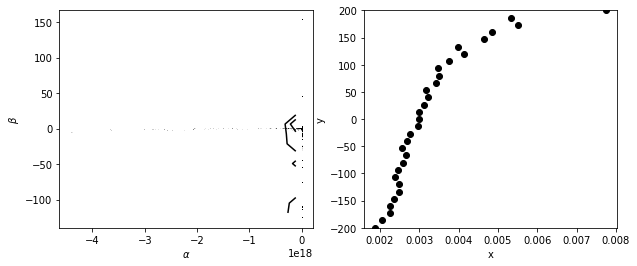

In [88]:
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# we'll throw-out the burn-in points and reshape:
emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, ndim).T
#plot_MCMC_results(data.Voltage_mV, data.Current_nA, emcee_trace)
plot_MCMC_results_GHK(data.Current_nA, data.Voltage_mV, emcee_trace)